In [2]:
setwd("/import/home/share/zw/pql")
getwd()

set.seed(20240709)

library(RhpcBLASctl)
max_cores <- 36
blas_set_num_threads(max_cores)

library(doParallel)
library(foreach)

library(spacexr)
library(SPARK)
library(Matrix)
# library(Seurat)

library(ggplot2)

[1] "/import/home/share/zw/pql"

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”


In [3]:
source("/import/home/share/zw/pql/code/mcube/mcubeClass.R")
source("/import/home/share/zw/pql/code/mcube/mcubeFitNull.R")
source("/import/home/share/zw/pql/code/mcube/mcubeScoreTest.R")
source("/import/home/share/zw/pql/code/mcube/mcubeUtils.R")
source("/import/home/share/zw/pql/code/mcube/mcubeKernel.R")
source("/import/home/share/zw/pql/code/mcube/mcubePlot.R")
source("/import/home/share/zw/pql/code/mcube/mcubeHelpers.R")

In [4]:
DATA_PATH <- "/import/home/share/zw/pql/data/breast_cancer"
RESULT_PATH <- "/import/home/share/zw/pql/results/breast_cancer"

if (!dir.exists(DATA_PATH)) {
    dir.create(DATA_PATH, recursive = TRUE)
}
if (!dir.exists(RESULT_PATH)) {
    dir.create(RESULT_PATH, recursive = TRUE)
}

## scRNA-seq data

In [4]:
sc_counts <- as.data.frame(readr::read_csv(file.path(DATA_PATH, "rawdata", "sc_counts.csv")))
rownames(sc_counts) <- sc_counts[, 1]
sc_counts[, 1] <- NULL
# head(sc_counts)

sc_celltype <- read.csv(file.path(DATA_PATH, "rawdata", "sc_celltype.csv"))
celltypes <- sc_celltype$celltype
names(celltypes) <- sc_celltype[, 1]
celltypes <- factor(celltypes, levels = unique(celltypes))

reference <- Reference(t(as.matrix(sc_counts)), celltypes, rowSums(sc_counts), min_UMI = 10)

New names:
• `` -> `...1`
Rows: 26031 Columns: 308
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): ...1
dbl (307): IL2RG, SNAI1, GLIPR1, OXTR, MYBPC1, MUC6, PDK4, KLRB1, RUNX1, DSP...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in check_UMI(nUMI, "Reference", require_2d = T, require_int = require_int, :
“Reference: some nUMI values are less than min_UMI = 10, and these cells will be removed. Optionally, you may lower the min_UMI parameter.”


## 10x

In [5]:
seg_method <- "Cell_10X"

counts <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "counts.csv")
))
rownames(counts) <- counts[, 1]
counts[, 1] <- NULL
counts <- as.matrix(counts)
# head(counts)

coordinates <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "coordinates.csv")
))
rownames(coordinates) <- coordinates[, 1]
coordinates[, 1] <- NULL
coordinates <- as.matrix(coordinates)
# head(coordinates)

scvi_label <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "scvi_label.csv")
))
rownames(scvi_label) <- scvi_label[, 1]
scvi_label <- scvi_label[, 2]
# head(scvi_label)

puck <- SpatialRNA(as.data.frame(coordinates), t(counts), rowSums(counts))

New names:
• `` -> `...1`
Rows: 10000 Columns: 308
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (308): ...1, SFRP1, PCLAF, CDC42EP1, LGALSL, CCL5, USP53, IGF1, ESM1, MN...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): ...1, x, y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): celltype
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_type

In [6]:
# myRCTD <- create.RCTD(puck, reference,
#     UMI_min = 50, keep_reference = TRUE, max_cores = max_cores
# )
# myRCTD <- run.RCTD(myRCTD, doublet_mode = 'multi')
# saveRDS(myRCTD, file.path(RESULT_PATH, seg_method, 'myRCTD.rds'))

myRCTD <- readRDS(file.path(RESULT_PATH, seg_method, 'myRCTD.rds'))

In [7]:
st_gene_names <- rownames(myRCTD@originalSpatialRNA@counts)
mt_genes <- grep("mt-", st_gene_names)
if(length(mt_genes)>0){
    st_gene_names <- st_gene_names[-mt_genes]
}

sc_gene_names <- rownames(myRCTD@reference@counts)
sc_mt_genes <- grep("mt-", sc_gene_names)
if(length(sc_mt_genes) > 0){
    sc_gene_names <- sc_gene_names[-sc_mt_genes]
}

spot_names <- colnames(myRCTD@spatialRNA@counts)
counts <- t(myRCTD@originalSpatialRNA@counts)[spot_names, st_gene_names]
library_size_RCTD <- myRCTD@spatialRNA@nUMI
coordinates <- myRCTD@spatialRNA@coords
sc_counts <- t(myRCTD@reference@counts)[, sc_gene_names]
sc_library_size_RCTD <- myRCTD@reference@nUMI
sc_labels <- myRCTD@reference@cell_types

# weights_RCTD <- as.matrix(myRCTD@results$weights)
weights_RCTD <- t(sapply(myRCTD@results, function(x) x$all_weights))
rownames(weights_RCTD) <- spot_names
colnames(weights_RCTD) <- myRCTD@cell_type_info$info[[2]]
proportion_RCTD <- weights_RCTD / rowSums(weights_RCTD)

spot_effects_RCTD <- log(rowSums(weights_RCTD))
names(spot_effects_RCTD) <- rownames(weights_RCTD)

reference_RCTD <- t(myRCTD@cell_type_info$info[[1]])
used_for_deconvolution <- rownames(myRCTD@spatialRNA@counts)

# write.csv(as.matrix(counts), file = file.path(DATA_PATH, seg_method, "counts.csv"))
# write.csv(as.matrix(library_size_RCTD), file = file.path(DATA_PATH, seg_method, "library_size_RCTD.csv"))
# write.csv(coordinates, file = file.path(DATA_PATH, seg_method, "coordinates.csv"))
# write.csv(as.matrix(sc_counts), file = file.path(DATA_PATH, seg_method, "sc_counts.csv"))
# write.csv(as.matrix(sc_library_size_RCTD), file = file.path(DATA_PATH, seg_method, "sc_library_size_RCTD.csv"))
# write.csv(as.matrix(sc_labels), file = file.path(DATA_PATH, seg_method, "sc_labels.csv"))

# write.csv(weights_RCTD, file = file.path(DATA_PATH, seg_method, "weights_RCTD.csv"))
# write.csv(reference_RCTD, file = file.path(DATA_PATH, seg_method, "reference_RCTD.csv"))

In [8]:
mcube_object <- createMCUBE(
    counts = counts, library_size = library_size_RCTD,
    coordinates = as.matrix(coordinates), covariates = NULL,
    proportion = proportion_RCTD, reference = reference_RCTD,
    used_for_deconvolution = used_for_deconvolution,
    spot_effects = spot_effects_RCTD, platform_effects = NULL,
    project = "Cell_10x"
)
mcube_object <- mcubeFitNull(mcube_object, max_cores = max_cores)
mcube_object <- mcubeTest(mcube_object, max_cores = max_cores)
# saveRDS(mcube_object,
#     file = file.path(
#         RESULT_PATH, seg_method,
#         paste0(
#             "mcube_object",
#             ".rds"
#         )
#     )
# )
saveRDS(mcube_object@pvalues,
    file = file.path(
        RESULT_PATH, seg_method,
        paste0(
            "mcube_pvalues",
            ".rds"
        )
    )
)

The sample_id is not provided!
All spots are assumed to come from the same sample/replicate/slice and share the same gene platform effects.

mcubeFilterCellTypes: Cell types IRF7+ DCs, Mast Cells, LAMP3+ DCs have less than the minimum celltype_threshold = 100. To include these cell-types, please reduce the celltype_threshold.

mcubeFilterCellTypes: Cell types Stromal, Macrophages 1, Perivascular-Like, Myoepi ACTA2+, CD4+ T Cells, DCIS 1, Prolif Invasive Tumor, Invasive Tumor, CD8+ T Cells, Endothelial, Macrophages 2, DCIS 2, B Cells, Myoepi KRT15+ pass the celltype_threshold = 100.

mcubeFilterGenes: Filter genes based on relative expression with threshold = 5e-05.

The platform effects are not provided and need to be estimated from data!

Preprocessed data description: 9120 spots, 293 genes, and 17 cell types in total. 9120 spots and 14 cell types to analyze.

Number of cores used: 36.

mcubeKernel: length scale is set as 0.0240773627124419 for the Gaussian kernel.

mcubeKernel: lengt

## UCS

In [9]:
seg_method <- "UCS_10X"

counts <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "counts.csv")
))
rownames(counts) <- counts[, 1]
counts[, 1] <- NULL
counts <- as.matrix(counts)
# head(counts)

coordinates <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "coordinates.csv")
))
rownames(coordinates) <- coordinates[, 1]
coordinates[, 1] <- NULL
coordinates <- as.matrix(coordinates)
# head(coordinates)

scvi_label <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "scvi_label.csv")
))
rownames(scvi_label) <- scvi_label[, 1]
scvi_label <- scvi_label[, 2]
# head(scvi_label)

puck <- SpatialRNA(as.data.frame(coordinates), t(counts), rowSums(counts))

New names:
• `` -> `...1`
Rows: 10000 Columns: 308
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (308): ...1, IL2RG, SNAI1, GLIPR1, OXTR, MYBPC1, MUC6, PDK4, KLRB1, RUNX...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): ...1, x, y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): celltype
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_type

In [10]:
# myRCTD <- create.RCTD(puck, reference,
#     UMI_min = 50, keep_reference = TRUE, max_cores = max_cores
# )
# myRCTD <- run.RCTD(myRCTD, doublet_mode = 'multi')
# saveRDS(myRCTD, file.path(RESULT_PATH, seg_method, 'myRCTD.rds'))

myRCTD <- readRDS(file.path(RESULT_PATH, seg_method, 'myRCTD.rds'))

In [11]:
st_gene_names <- rownames(myRCTD@originalSpatialRNA@counts)
mt_genes <- grep("mt-", st_gene_names)
if(length(mt_genes)>0){
    st_gene_names <- st_gene_names[-mt_genes]
}

sc_gene_names <- rownames(myRCTD@reference@counts)
sc_mt_genes <- grep("mt-", sc_gene_names)
if(length(sc_mt_genes) > 0){
    sc_gene_names <- sc_gene_names[-sc_mt_genes]
}

spot_names <- colnames(myRCTD@spatialRNA@counts)
counts <- t(myRCTD@originalSpatialRNA@counts)[spot_names, st_gene_names]
library_size_RCTD <- myRCTD@spatialRNA@nUMI
coordinates <- myRCTD@spatialRNA@coords
sc_counts <- t(myRCTD@reference@counts)[, sc_gene_names]
sc_library_size_RCTD <- myRCTD@reference@nUMI
sc_labels <- myRCTD@reference@cell_types

# weights_RCTD <- as.matrix(myRCTD@results$weights)
weights_RCTD <- t(sapply(myRCTD@results, function(x) x$all_weights))
rownames(weights_RCTD) <- spot_names
colnames(weights_RCTD) <- myRCTD@cell_type_info$info[[2]]
proportion_RCTD <- weights_RCTD / rowSums(weights_RCTD)

spot_effects_RCTD <- log(rowSums(weights_RCTD))
names(spot_effects_RCTD) <- rownames(weights_RCTD)

reference_RCTD <- t(myRCTD@cell_type_info$info[[1]])
used_for_deconvolution <- rownames(myRCTD@spatialRNA@counts)

# write.csv(as.matrix(counts), file = file.path(DATA_PATH, seg_method, "counts.csv"))
# write.csv(as.matrix(library_size_RCTD), file = file.path(DATA_PATH, seg_method, "library_size_RCTD.csv"))
# write.csv(coordinates, file = file.path(DATA_PATH, seg_method, "coordinates.csv"))
# write.csv(as.matrix(sc_counts), file = file.path(DATA_PATH, seg_method, "sc_counts.csv"))
# write.csv(as.matrix(sc_library_size_RCTD), file = file.path(DATA_PATH, seg_method, "sc_library_size_RCTD.csv"))
# write.csv(as.matrix(sc_labels), file = file.path(DATA_PATH, seg_method, "sc_labels.csv"))

# write.csv(weights_RCTD, file = file.path(DATA_PATH, seg_method, "weights_RCTD.csv"))
# write.csv(reference_RCTD, file = file.path(DATA_PATH, seg_method, "reference_RCTD.csv"))

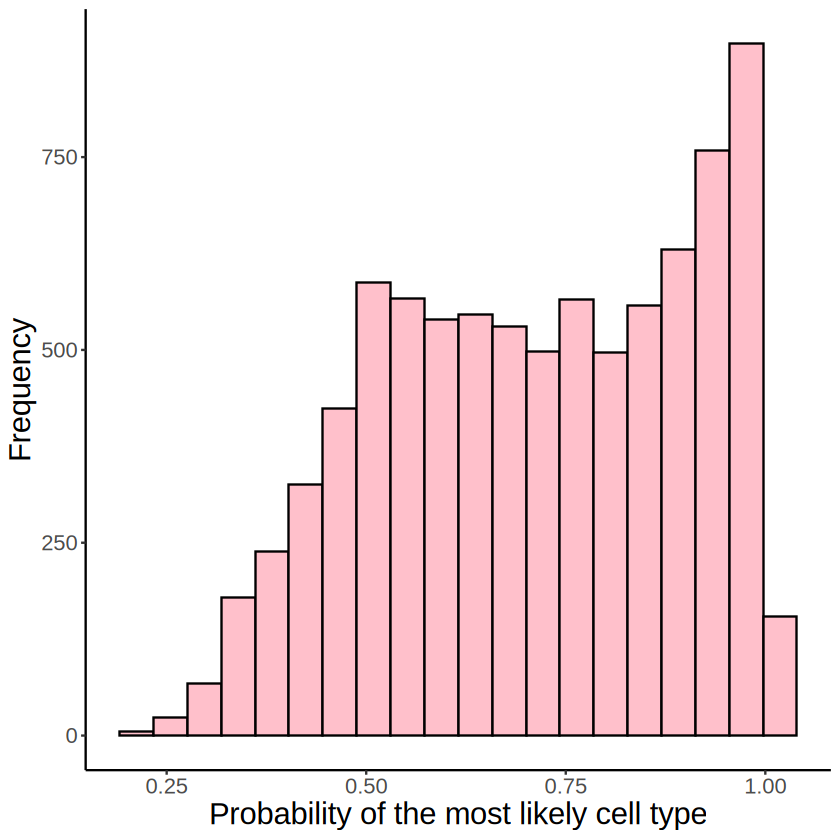

In [12]:
p <- ggplot(NULL, aes(apply(proportion_RCTD, 1, max))) +
    geom_histogram(bins = 20, fill = "pink", color = "black") +
    theme_classic() +
    labs(
        title = NULL,
        x = "Probability of the most likely cell type",
        y = "Frequency"
    ) +
    theme(
        axis.title = element_text(size = 18),
        text = element_text(size = 16),
    )
p
ggsave(file = file.path(RESULT_PATH, "hist_most_likely_celltype.png"), plot = p, width = 5, height = 4)
ggsave(file = file.path(RESULT_PATH, "hist_most_likely_celltype.pdf"), plot = p, width = 5, height = 4)

In [13]:
mcube_object <- createMCUBE(
    counts = counts, library_size = library_size_RCTD,
    coordinates = as.matrix(coordinates), covariates = NULL,
    proportion = proportion_RCTD, reference = reference_RCTD,
    used_for_deconvolution = used_for_deconvolution,
    spot_effects = spot_effects_RCTD, platform_effects = NULL,
    project = "UCS_10x"
)
mcube_object <- mcubeFitNull(mcube_object, max_cores = max_cores, verbose = FALSE)
mcube_object <- mcubeTest(mcube_object, max_cores = max_cores)
# saveRDS(mcube_object,
#     file = file.path(
#         RESULT_PATH, seg_method,
#         paste0(
#             "mcube_object",
#             ".rds"
#         )
#     )
# )
saveRDS(mcube_object@pvalues,
    file = file.path(
        RESULT_PATH, seg_method,
        paste0(
            "mcube_pvalues",
            ".rds"
        )
    )
)

The sample_id is not provided!
All spots are assumed to come from the same sample/replicate/slice and share the same gene platform effects.

mcubeFilterCellTypes: Cell types IRF7+ DCs, Mast Cells, LAMP3+ DCs have less than the minimum celltype_threshold = 100. To include these cell-types, please reduce the celltype_threshold.

mcubeFilterCellTypes: Cell types Stromal, Macrophages 1, Perivascular-Like, Myoepi ACTA2+, CD4+ T Cells, DCIS 1, Prolif Invasive Tumor, Invasive Tumor, CD8+ T Cells, Endothelial, Macrophages 2, DCIS 2, B Cells, Myoepi KRT15+ pass the celltype_threshold = 100.

mcubeFilterGenes: Filter genes based on relative expression with threshold = 5e-05.

The platform effects are not provided and need to be estimated from data!

Preprocessed data description: 8593 spots, 290 genes, and 17 cell types in total. 8593 spots and 14 cell types to analyze.

Number of cores used: 36.



## P-values comparsion between 10x and UCS

In [14]:
pvalues_10X <- readRDS(
    file = file.path(
        RESULT_PATH, "Cell_10X",
        paste0(
            "mcube_pvalues",
            ".rds"
        )
    )
)

pvalues_UCS <- readRDS(
    file = file.path(
        RESULT_PATH, "UCS_10X",
        paste0(
            "mcube_pvalues",
            ".rds"
        )
    )
)

In [15]:
pvalues_10X_long <- do.call(
    rbind,
    lapply(
        names(pvalues_10X),
        FUN = function(x) {
            data.frame(
                celltype = x,
                gene = rownames(pvalues_10X[[x]]),
                pvalue = pvalues_10X[[x]][, "combined_pvalue"]
            )
        }
    )
)

pvalues_UCS_long <- do.call(
    rbind,
    lapply(
        names(pvalues_UCS),
        FUN = function(x) {
            data.frame(
                celltype = x,
                gene = rownames(pvalues_UCS[[x]]),
                pvalue = pvalues_UCS[[x]][, "combined_pvalue"]
            )
        }
    )
)

In [ ]:
pvalues_all <- merge(
    pvalues_10X_long,
    pvalues_UCS_long,
    by = c("celltype", "gene"),
    suffixes = c("_10X", "_UCS")
)
dim(pvalues_all)
head(pvalues_all)

In [ ]:
log10p_lim <- 17 # 5.55e-17
# log10p_lim <- 50
major_celltypes <- c("Invasive Tumor", "Stromal", "DCIS 1", "DCIS 2", "Prolif Invasive Tumor", "Endothelial", "Myoepi ACTA2+", "Myoepi KRT15+")
pvalues_all_major_celltype <- pvalues_all[pvalues_all$celltype %in% major_celltypes, ]
pvalues_all_major_celltype$celltype <- factor(
    pvalues_all_major_celltype$celltype,
    levels = major_celltypes
)

p <- ggplot(
    # pvalues_all,
    pvalues_all_major_celltype,
    aes(x = -log10(pvalue_10X), y = -log10(pvalue_UCS))
) +
    geom_point(aes(color = celltype), size = 5, alpha = 0.8) +
        geom_abline(
            intercept = 0, slope = 1,
            linetype = "dashed", linewidth = 2
        ) +
    scale_x_continuous(limits = c(0, log10p_lim), oob = scales::oob_squish) +
        scale_y_continuous(limits = c(0, log10p_lim), oob = scales::oob_squish) +
        coord_fixed(ratio = 1) +
        facet_wrap(~celltype, nrow = 1) +
        theme_classic() +
        labs(
            x = "10x", y = "UCS",
            title = expression(paste("-log"[10], plain(P), " from MMM"))
        ) +
        guides(color = guide_legend(nrow = 1)) +
        theme(
            plot.title = element_text(size = 20),
            axis.title = element_text(size = 20),
            axis.text.x = element_text(size = 16),
            axis.text.y = element_text(size = 16),
            strip.text = element_blank(),
            legend.title = element_blank(),
            legend.text = element_text(size = 16),
            legend.position = "bottom"
        )
ggsave(
    filename = file.path(
        RESULT_PATH, paste0("MMM_seg_comparison_oob_squish_", log10p_lim, ".pdf")
    ),
    plot = p, width = 18, height = 4
)
p

In [ ]:
# log10p_lim <- 17 # 5.55e-17
log10p_lim <- 30
major_celltypes <- c("Invasive Tumor", "Stromal", "DCIS 1", "DCIS 2", "Prolif Invasive Tumor", "Endothelial", "Myoepi ACTA2+", "Myoepi KRT15+")
pvalues_all_major_celltype <- pvalues_all[pvalues_all$celltype %in% major_celltypes, ]
pvalues_all_major_celltype$celltype <- factor(
    pvalues_all_major_celltype$celltype,
    levels = major_celltypes
)

p <- ggplot(
    # pvalues_all,
    pvalues_all_major_celltype,
    aes(x = -log10(pvalue_10X), y = -log10(pvalue_UCS))
) +
    geom_point(aes(color = celltype), size = 5, alpha = 0.8) +
        geom_abline(
            intercept = 0, slope = 1,
            linetype = "dashed", linewidth = 2
        ) +
    scale_x_continuous(limits = c(0, log10p_lim), oob = scales::oob_squish) +
        scale_y_continuous(limits = c(0, log10p_lim), oob = scales::oob_squish) +
        coord_fixed(ratio = 1) +
        facet_wrap(~celltype, nrow = 1) +
        theme_classic() +
        labs(
            x = "10x", y = "UCS",
            title = expression(paste("-log"[10], plain(P), " from MMM"))
        ) + 
        guides(color = guide_legend(nrow = 1)) +
        theme(
            plot.title = element_text(size = 20),
            axis.title = element_text(size = 20),
            axis.text.x = element_text(size = 16),
            axis.text.y = element_text(size = 16),
            strip.text = element_blank(),
            legend.title = element_blank(),
            legend.text = element_text(size = 16),
            legend.position = "bottom"
        )
ggsave(
    filename = file.path(
        RESULT_PATH, paste0("MMM_seg_comparison_oob_squish_", log10p_lim, ".pdf")
    ),
    plot = p, width = 18, height = 4
)
p

In [ ]:
# major_celltypes <- c("DCIS 1", "DCIS 2", "Prolif Invasive Tumor", "Endothelial", "Myoepi ACTA2+", "Myoepi KRT15+")
major_celltypes <- c("Invasive Tumor", "Stromal", "DCIS 1", "DCIS 2", "Prolif Invasive Tumor", "Endothelial", "Myoepi ACTA2+", "Myoepi KRT15+")
pvalues_all_major_celltype <- pvalues_all[pvalues_all$celltype %in% major_celltypes, ]
pvalues_all_major_celltype$celltype <- factor(
    pvalues_all_major_celltype$celltype,
    levels = major_celltypes
)

p <- ggplot(
    # pvalues_all,
    pvalues_all_major_celltype,
    aes(x = -log10(pvalue_10X), y = -log10(pvalue_UCS))
) +
    geom_point(aes(color = celltype), size = 5, alpha = 0.8) +
        geom_abline(
            intercept = 0, slope = 1,
            linetype = "longdash", linewidth = 2
        ) +
    # scale_x_continuous(limits = c(0, log10p_lim), oob = scales::oob_squish) +
    #  scale_y_continuous(limits = c(0, log10p_lim), oob = scales::oob_squish) +
        coord_fixed(ratio = 1) +
        facet_wrap(~celltype, nrow = 1) +
        theme_classic() +
        labs(
            x = "10x", y = "UCS",
            title = "MMM"
        ) + 
        guides(color = guide_legend(nrow = 1)) +
        theme(
            plot.title = element_text(size = 20),
            axis.title = element_text(size = 20),
            axis.text.x = element_text(size = 16),
            axis.text.y = element_text(size = 16),
            strip.text = element_blank(),
            legend.title = element_blank(),
            legend.text = element_text(size = 16),
            legend.position = "bottom"
        )
    ggsave(
        filename = file.path(RESULT_PATH, "MMM_seg_comparison.pdf"),
        plot = p,
        width = 18,
        height = 4
    )
    
p

## Proportion

In [5]:
mcube_object <- readRDS(
    file = file.path(
        RESULT_PATH, "UCS_10X",
        paste0(
            "mcube_object",
            ".rds"
        )
    )
)

In [6]:
library(tiff)
library(grid)
library(nara)
he_image <- readTIFF(file.path(DATA_PATH, "he.tif"), native = TRUE)
he_image <- nr_flipv(he_image)
he_image <- nr_fliph(he_image)

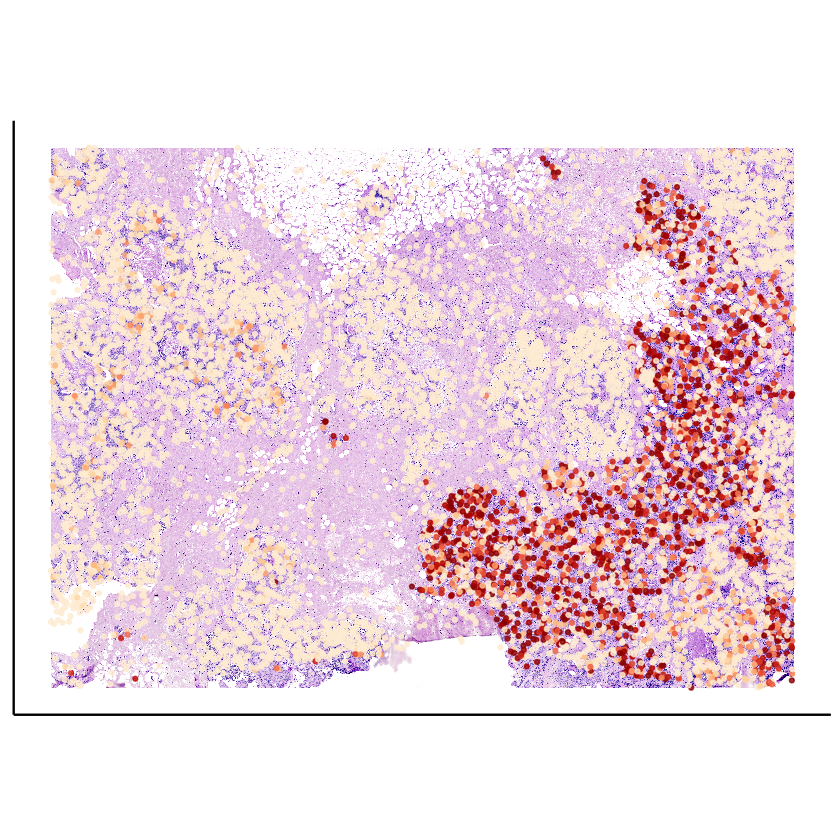

In [7]:
celltype <- "Invasive Tumor"
plot_df <- data.frame(
    x = mcube_object@coordinates[, 2],
    y = mcube_object@coordinates[, 1],
    prop = mcube_object@proportion[, celltype]
)
plot_df <- plot_df[plot_df$prop > 0, , drop = FALSE]
p <- ggplot(data = plot_df, aes(x = x, y = y))

p <- p + annotation_raster(
    he_image,
    xmin = -max(mcube_object@coordinates[, 2]), xmax = 0,
    ymin = 0, ymax = max(mcube_object@coordinates[, 1])
)
p <- p + 
    geom_point(aes(color = prop), size = 0.7, alpha = 0.8) +
    scale_x_continuous(transform = "reverse") +
    scale_colour_gradientn(name = NULL, colors = pals::brewer.orrd(22)[3:22]) +
    coord_fixed(ratio = 1) +
    labs(title = NULL, x = NULL, y = NULL) +
    theme_classic() +
    theme(
        # plot.title = element_text(size = 24, hjust = 0.5),
        text = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "none"
    )
ggsave(
    filename = file.path(RESULT_PATH, paste0(celltype, "_proportion.png")),
    plot = p, width = 7, height = 5
)
p

## SVGs

In [9]:
sig_genes <- mcubeGetSigGenes(mcube_object@pvalues)

mcubeGetSigGenes: Set adjust_method as BH and alpha as 0.05.



### DCIS 1

In [10]:
celltype <- "DCIS 1"
head(sig_genes[[celltype]])

,pvalue,adjusted_pvalue
,<dbl>,<dbl>
SERPINA3,9.139841e-54,5.392506e-52
ESR1,4.216125e-32,1.243757e-30
FLNB,6.357245e-24,1.250258e-22
SCD,3.182174e-20,4.693706e-19
TACSTD2,9.011551e-18,1.063363e-16
ERBB2,4.662937e-15,4.585221e-14


In [25]:
demo_genes <- c("ESR1", "FLNB", "SCD")
for (gene in demo_genes) {
    pair_name <- paste(celltype, gene, sep = "_")
    null_model_results <- mcube_object@null_models[[pair_name]]
    spots <- null_model_results$spots
    u <- null_model_results$u[spots, celltype]
    rel_expr_level <- factor(ifelse(u >= 0, 1, 0))
    plot_df <- data.frame(
        x = mcube_object@coordinates[spots, 2],
        y = mcube_object@coordinates[spots, 1],
        rel_expr_level = rel_expr_level
    )

    p <- ggplot(data = plot_df, aes(x = x, y = y))

    p <- p + annotation_raster(
        he_image,
        xmin = -max(mcube_object@coordinates[, 2]), xmax = 0,
        ymin = 0, ymax = max(mcube_object@coordinates[, 1])
    )

    p <- p + geom_point(aes(color = rel_expr_level), size = 0.8, alpha = 0.95) +
        scale_color_manual(name = "Level", values = c(`0` = "#32CD32", `1` = "#FF69B4")) +
        scale_x_continuous(transform = "reverse") +
        coord_fixed(ratio = 1) +
        labs(title = NULL, x = NULL, y = NULL) +
        theme_classic() +
        theme(
            # plot.title = element_text(size = 24, hjust = 0.5),
            text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = "none"
        )
    ggsave(
        filename = file.path(RESULT_PATH, paste0(celltype, "_", gene, ".png")),
        plot = p, width = 7, height = 5
    )
}

### DCIS 2

In [11]:
celltype <- "DCIS 2"
head(sig_genes[[celltype]])

,pvalue,adjusted_pvalue
,<dbl>,<dbl>
CEACAM6,1.230439e-123,7.259589e-122
SCD,2.075818e-98,6.123664e-97
SERPINA3,6.554515e-98,1.289055e-96
TENT5C,1.340680e-77,1.977503e-76
KRT7,3.594577e-66,4.241601e-65
ERBB2,1.298020e-55,1.276386e-54


In [27]:
demo_genes <- c("CEACAM6", "SERPINA3", "TENT5C")
for (gene in demo_genes) {
    pair_name <- paste(celltype, gene, sep = "_")
    null_model_results <- mcube_object@null_models[[pair_name]]
    spots <- null_model_results$spots
    u <- null_model_results$u[spots, celltype]
    rel_expr_level <- factor(ifelse(u >= 0, 1, 0))
    plot_df <- data.frame(
        x = mcube_object@coordinates[spots, 2],
        y = mcube_object@coordinates[spots, 1],
        rel_expr_level = rel_expr_level
    )

    p <- ggplot(data = plot_df, aes(x = x, y = y))

    p <- p + annotation_raster(
        he_image,
        xmin = -max(mcube_object@coordinates[, 2]), xmax = 0,
        ymin = 0, ymax = max(mcube_object@coordinates[, 1])
    )

    p <- p + geom_point(aes(color = rel_expr_level), size = 0.8, alpha = 0.95) +
        scale_color_manual(name = "Level", values = c(`0` = "#32CD32", `1` = "#FF69B4")) +
        scale_x_continuous(transform = "reverse") +
        coord_fixed(ratio = 1) +
        labs(title = NULL, x = NULL, y = NULL) +
        theme_classic() +
        theme(
            # plot.title = element_text(size = 24, hjust = 0.5),
            text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = "none"
        )
    ggsave(
        filename = file.path(RESULT_PATH, paste0(celltype, "_", gene, ".png")),
        plot = p, width = 7, height = 5
    )
}

In [6]:
celltype <- "DCIS 2"
sig_genes <- mcubeGetSigGenes(pvalues_UCS)

write.table(
    rownames(sig_genes[[celltype]]),
    file = file.path(
        RESULT_PATH,
        paste0("SVG_", celltype, ".txt")
    ),
    quote = FALSE, row.names = FALSE, col.names = FALSE
)

mcubeGetSigGenes: Set adjust_method as BH and alpha as 0.05.

